In [2]:
# Импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Настройки для графиков
sns.set(style='whitegrid',
        font_scale=1.2,
        rc={'figure.figsize': (14, 6)})

In [4]:
# Функция для подписи графика
def sets_for_plot(plot, title='', title_fontsize=22, 
                  xlabel='', xlabel_fontsize=18, 
                  ylabel='', ylabel_fontsize=18):
    
    plot.set_title(title, fontsize=title_fontsize)
    plot.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    plot.set_ylabel(ylabel, fontsize=ylabel_fontsize)

# Импорт данных

Международные пассажирские авиаперевозки
В тысячах человек, по месяцам
С января 1949 по декабрь 1960 года.

Сделать предсказание на следующий месяц (2)

In [5]:
# Импорт обучающей выборки
series_df = pd.read_csv('series_g.csv', sep=';', header=0)

In [6]:
#  Знакомимся с данными
series_df

,date,series_g
0,JAN 1949,112
1,FEB 1949,118
2,MAR 1949,132
3,APR 1949,129
4,MAY 1949,121
...,...,...
139,AUG 1960,606
140,SEP 1960,508
141,OCT 1960,461
142,NOV 1960,390


In [7]:
# Проверка нулевых значений. И типов данных
series_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      144 non-null    object
 1   series_g  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
# Преобразуем в дату
series_df.date = pd.to_datetime(series_df.date)
series_df.head()

,date,series_g
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


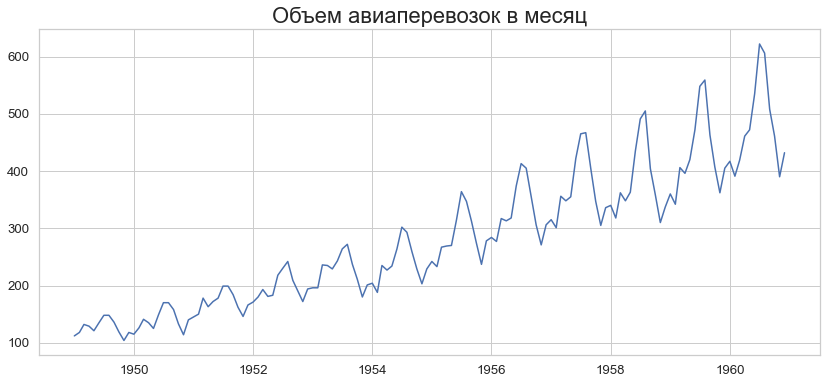

In [9]:
# График
lp = sns.lineplot(data=series_df, x='date', y='series_g')
sets_for_plot(lp, title='Объем авиаперевозок в месяц')

В данных ярко выраженная сезонность каждый год. Также с каждым годом растет размах объемов, это может вносить дополнительную сложность для модели.

# Feature engineering

In [10]:
# Функция для преобразования данных во временной ряд с окном в 12
def to_time_series(data, column):
    df = pd.DataFrame()
    for i in range(12,0,-1):
        df['m-'+str(i)] = data[column].shift(i)
    df['m'] = data[column].values
    return df[12:]


In [11]:
# Преобразуем данные
time_series_df = to_time_series(series_df, 'series_g')

In [12]:
#  X и у
y = time_series_df['m'].values
X = time_series_df.drop('m', axis=1)

In [13]:
# Стандартизируем данные для нейросети
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [14]:
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1,1))

In [15]:
#  Разделяем на обучающую и тестовую выборки
#  Тестовая - последние наблюдения
X_train = X[:120]
y_train = y[:120]
X_test  = X[120:]
y_test  = y[120:]

# Baseline

### Обучим базовую нейросеть 2 слоями

In [16]:
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [17]:
# Функция для обучения базовой модели нейронной сети
def fit_basic_model(trainX, trainY):
    # Creating a model
    model = Sequential()
    model.add(Dense(8, input_dim=12, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compiling model
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Training a model
    model.fit(trainX, trainY, epochs=300, batch_size=None, verbose=0)
    
    return model

In [18]:
# Функция для получения следующей строки для прогноза
def next_test_row(row, y_predict):
    row = np.append(row, y_predict)
    row = np.delete(row, 0)
    return row.reshape(1,12)

In [19]:
# Функция генерирующая тестовую выборку на 12 периодов для модели
def generate_true_X_test(model, X_row):
    # Начальные данные
    X_test_true = X_row
    y_predict = model.predict(X_test_true)
    X_row = X_test_true.copy()
    
    for _ in range(11):
        # Получаем следующую строку
        X_row = next_test_row(X_row, y_predict)
        # Делаем предикт для новой строки
        y_predict = model.predict(X_row)
        # Добавляем в выборку
        X_test_true = np.append(X_test_true, X_row)

    return X_test_true.reshape(12, 12)

Т.к. модель может застрять в локальном минимуме построим нейросеть 100 раз для выбора лучшей. Определять лучшую будем по минимальному MSE для тестовой выборки. Тестовую выборку в свою очередь преобразуем следующим образом: мы предпологаем, что данных теста у нас нет, поэтому модель дает прогноз, а дальше прогнозирует основываясь на своем прогнозе и т.д.. Это увеличит нам MSE, но даст более точное понимание работы модели

In [20]:
# Функция для обучения 100 разных моделей, возвращает модель с мин MSE
def fit_100_models(trainX, trainY, testX, testY):
    # Начальные данные
    best_score = float('inf')
    X_row = testX[0:1]
    for i in range(1, 101):
        print(f'Run {i}:')
        # Обучаем новую модель
        model = fit_basic_model(trainX, trainY)

        # Генерируем для нее тестовую выборку
        X_test_true = generate_true_X_test(model, X_row)

        # Сравниваем результаты
        score = model.evaluate(X_test_true, testY, verbose=0)
        print(f'MSE: {round(score, 4)}')

        if score < best_score:
            best_model = model
            best_score = score
        
    return best_model, best_score

In [21]:
# Функция рисует график с результатами обучения
def result_plot(model, trainX, trainY, testX, testY, title):
    # Вычисляем прогноз
    predictions_test = model.predict(testX)
    
    # Вычисляем подгонку
    predictions_train = model.predict(trainX)
    
    # Преобразования для графика
    data = np.concatenate([trainY, testY])
    predict = pd.DataFrame(predictions_test).set_index(np.arange(120, 132))
    
    # Построение графика
    sns.lineplot(data=data,              palette=['blue'], linewidth = 2, legend=False)
    sns.lineplot(data=predictions_train, palette=['green'],  linewidth = 2, legend=False)
    sns.lineplot(data=predict,           palette=['red'],  linewidth = 2, legend=False)

    plt.title(title, fontsize=22);

In [22]:
# Найдем лучшую модель за 100 прогонов
# basic_model, basic_score = fit_100_models(X_train, y_train, X_test, y_test)

In [23]:
# Загружаем ранее обученную модель
basic_model = load_model('basic_model.h5')

In [24]:
# Генерируем тестовую для лучшей модели
X_test_basic_model = generate_true_X_test(basic_model, X_test[0:1])

In [25]:
basic_score = basic_model.evaluate(X_test_basic_model, y_test, verbose=0)

In [26]:
# Результаты
print(f'MSE: {round(basic_score, 4)}')

MSE: 0.0011


In [27]:
# Сохраняем модель
#save_model(basic_model, 'basic_model.h5')

In [28]:
# Генерируем тестовую для лучшей модели
X_test_basic_model = generate_true_X_test(basic_model, X_test[0:1])

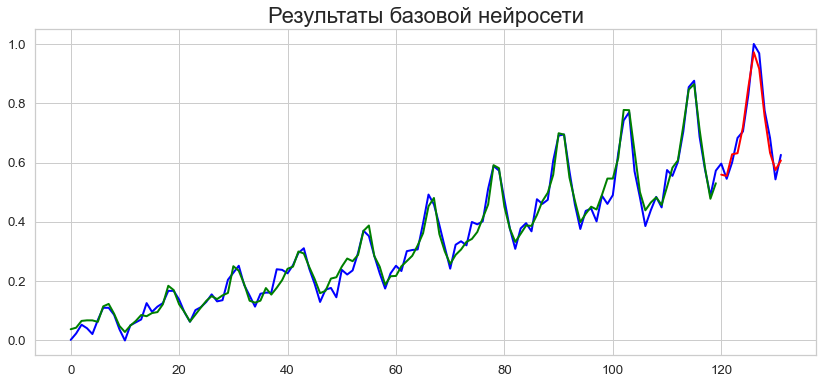

In [29]:
result_plot(basic_model, X_train, y_train, X_test_basic_model, y_test, 
            title='Результаты базовой нейросети')

Видим, что нейросеть чувствует амплитуду и сезонность. В целом хороший прогноз

### Проверим модель на изначальном тестовом множестве

In [30]:
# Модель с лучшим результатом на тестовой выборке
basic_scores_test = basic_model.evaluate(X_test, y_test)
print(f'MSE: {round(basic_scores_test, 4)}')

1/1 [==============================] - 0s 13ms/step - loss: 8.0788e-04
MSE: 0.0008


In [31]:
# Вычисляем прогноз на изначальном тестовом
predictions_true = basic_model.predict(X_test)
predictions_test = basic_model.predict(X_test_basic_model)

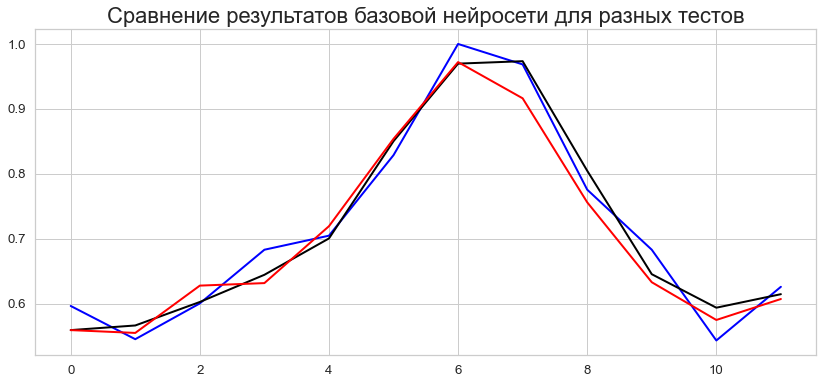

In [32]:
sns.lineplot(data=y_test,           palette=['blue'], linewidth = 2, legend=False)
sns.lineplot(data=predictions_true, palette=['black'],linewidth = 2, legend=False)
sns.lineplot(data=predictions_test, palette=['red'],  linewidth = 2, legend=False)

plt.title('Сравнение результатов базовой нейросети для разных тестов', fontsize=22);

Действительно, для изначального тестового набора MSE ниже и график ближе к синей линии

# Тюнинг модели

Сперва проверим все тоже самое, но предварительно прологарифмируем данные, чтобы убрать рост размаха

In [33]:
# Логарифмирование данных
series_df['log_y'] = np.log(series_df['series_g'])

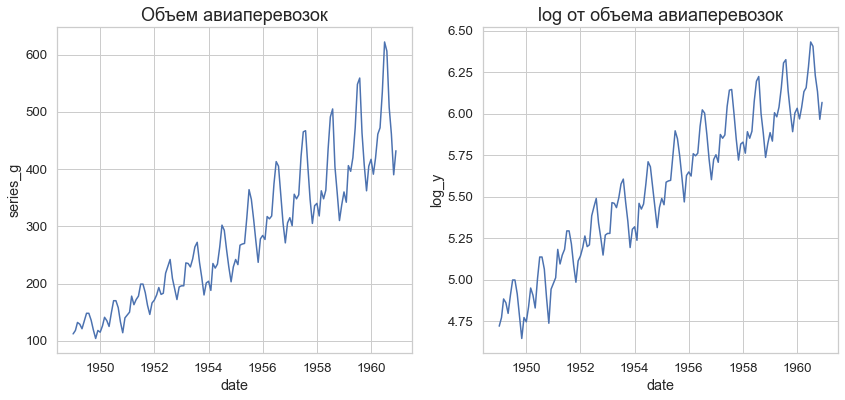

In [34]:
# График
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.lineplot(data=series_df, x='date', y='series_g', ax=ax1)
sns.lineplot(data=series_df, x='date', y='log_y',    ax=ax2)

ax1.set_title('Объем авиаперевозок', fontsize=18)
ax2.set_title('log от объема авиаперевозок', fontsize=18);

### Новые обучающие выборки

In [35]:
# Преобразуем данные
time_series_log_df = to_time_series(series_df, 'log_y')

In [36]:
#  X и у
y_log = time_series_log_df['m'].values
X_log = time_series_log_df.drop('m', axis=1)

In [37]:
# Стандартизируем данные для нейросети
scaler_X_log = MinMaxScaler()
scaler_y_log = MinMaxScaler()

In [38]:
X_log = scaler_X_log.fit_transform(X_log)
y_log = scaler_y_log.fit_transform(y_log.reshape(-1,1))

In [39]:
#  Разделяем на обучающую и тестовую выборки
#  Тестовая - последние наблюдения
X_train_log = X_log[:120]
y_train_log = y_log[:120]
X_test_log  = X_log[120:]
y_test_log  = y_log[120:]

### Обучение модели с логарифмированными данными

In [40]:
# Найдем лучшую модель за 100 прогонов
# basic_model_log, basic_score_log = fit_100_models(X_train_log, y_train_log, X_test_log, y_test_log)

In [70]:
# Загружаем ранее обученную модель
basic_model_log = load_model('basic_model_log.h5')

In [71]:
# Генерируем тестовую для лучшей модели
X_test_basic_model_log = generate_true_X_test(basic_model_log, X_test_log[0:1])

In [72]:
basic_scorec_log = basic_model_log.evaluate(X_test_basic_model_log, y_test_log, verbose=0)

In [73]:
# Результаты
print(f'MSE: {round(basic_scorec_log, 4)}')

MSE: 0.0003


In [45]:
# Сохраняем модель
#save_model(basic_model_log, 'basic_model_log.h5')

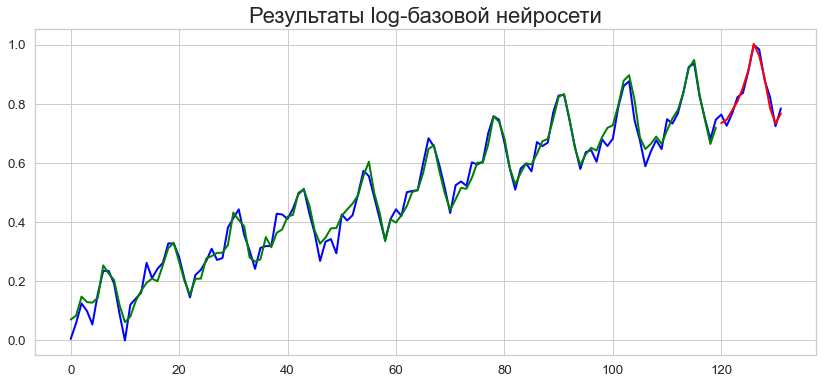

In [46]:
result_plot(basic_model_log, X_train_log, y_train_log, X_test_basic_model_log, y_test_log,
           title='Результаты log-базовой нейросети')

Видим, что если убрать фактор роста размаха данных, то модель в разы лучше ловит закономерности, прогноз на тестовую выборку (сгенерированную по прогнозным данным) практически идеальный.

### Попробуем еще улучшить логарифмическую модель изменяя архитектуру нейросети

In [47]:
from keras import initializers
import itertools

In [48]:
# Функция для обучения базовой модели нейронной сети
def fit_model(trainX, trainY, units_neurons, activation_func, optimizer):
    
    # Creating a model
    model = Sequential()
    model.add(Dense(units_neurons, input_dim=12, activation=activation_func))
    model.add(Dense(1, activation='linear'))

    # Compiling model
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    # Training a model
    model.fit(trainX, trainY, epochs=300, batch_size=None, verbose=0)
    
    return model

In [68]:
# Параметры для перебора
units_neurons = [4, 6, 8]
activation_func = ['relu', 'elu']

sgd = tf.keras.optimizers.SGD(lr=0.02, decay=1e-6, momentum=0.8, nesterov=True)
optimizer = ['adam', sgd];

In [50]:
# Функция для обучения 100 разных моделей, возвращает модель с мин MSE
def fit_100_models_with_params(trainX, trainY, testX, testY, p1, p2, p3):
    # Начальные данные
    best_score = float('inf')
    X_row = testX[0:1]
    
    # Комбинируем параметры
    params_list = list(itertools.product(p1, p2, p3))
    
    # С каждым набором параметро прогоняем 100 раз и находим лучший результат
    for param in params_list:
        units_neurons, activation_func, optimizer = param
        print(f'Параметры модели: \
              \nКоличество нейронов 2 слоя = {units_neurons}  \
              \nАктивационная функция = {activation_func} \
              \nОптимизатор = {optimizer}\n')
        
        # Переменная для отслеживания результата лучшей модели с этими параметрами
        best_score_with_params = float('inf')
        
        for i in range(1, 101):
            # Обучаем новую модель
            model = fit_model(trainX, trainY, units_neurons, activation_func, optimizer)

            # Генерируем для нее тестовую выборку
            X_test_true = generate_true_X_test(model, X_row)

            # Сравниваем результаты
            score = model.evaluate(X_test_true, testY, verbose=0)
            
            # Ищем лучший скор для модели с этими параметрами
            if score < best_score_with_params:
                best_score_with_params = score
                
            # Ищем лучшую модель в целом
            if score < best_score:
                best_model = model
                best_score = score
                
        print(f'Лучший MSE: {round(best_score_with_params, 4)}\n\n------------\n')
    
    print('Конец обучения')
    return best_model, best_score

In [51]:
%%time
# Найдем лучшую модель за 100 прогонов
tuning_model_log, tuning_score_log = fit_100_models_with_params(X_train_log, y_train_log, 
                                                                X_test_log, y_test_log,
                                                                units_neurons, activation_func, optimizer)

Параметры модели:               
Количество нейронов 2 слоя = 4                
Активационная функция = relu               
Оптимизатор = adam

Лучший MSE: 0.0008

------------

Параметры модели:               
Количество нейронов 2 слоя = 4                
Активационная функция = relu               
Оптимизатор = <keras.optimizer_v2.gradient_descent.SGD object at 0x00000212CFCB0A60>

Лучший MSE: 0.0007

------------

Параметры модели:               
Количество нейронов 2 слоя = 4                
Активационная функция = elu               
Оптимизатор = adam

Лучший MSE: 0.0006

------------

Параметры модели:               
Количество нейронов 2 слоя = 4                
Активационная функция = elu               
Оптимизатор = <keras.optimizer_v2.gradient_descent.SGD object at 0x00000212CFCB0A60>

Лучший MSE: 0.0006

------------

Параметры модели:               
Количество нейронов 2 слоя = 6                
Активационная функция = relu               
Оптимизатор = adam

Лучший MSE: 0.

По обучению можно сделать вывод, что сеть с 4 нейронами также дает неплохие результаты, в целом 8 нейронов может и не требоваться.

Пробовал использовать начальные значения весов из усеченного нормального распределения, но это только портило результат, возможно использование другого метода сработает лучше.

Это планы на дальнейшее исследование, если они понадобятся

In [52]:
# Результаты
# Параметры модели:               
# Количество нейронов 2 слоя = 4                
# Активационная функция = relu               
# Оптимизатор = <keras.optimizer_v2.gradient_descent.SGD object at 0x00000223B0779E70>

# Лучший MSE: 0.0013
print(f'MSE: {round(tuning_score_log, 4)}')

MSE: 0.0005


In [53]:
# Сохраняем модель
#save_model(tuning_model_log, 'tuning_model_log.h5')

In [54]:
# Генерируем тестовую для лучшей модели
X_test_tuning_model_log = generate_true_X_test(tuning_model_log, X_test_log[0:1])

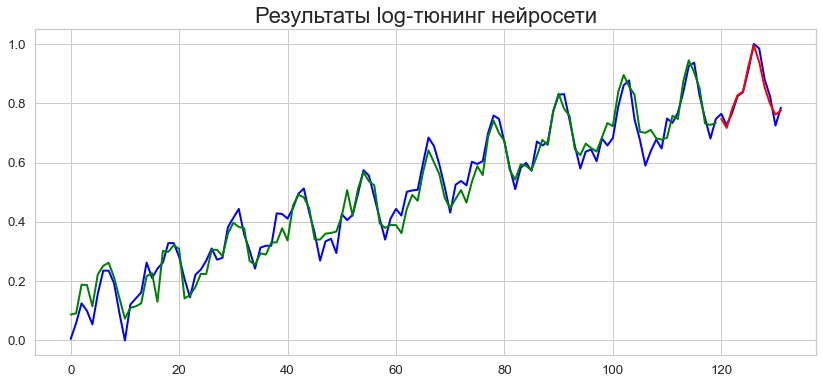

In [55]:
result_plot(tuning_model_log, X_train_log, y_train_log, X_test_tuning_model_log, y_test_log,
           title='Результаты log-тюнинг нейросети')

Чтобы сравнить модели между собой необходимо откатить логарифмирование и стандартизацию

# Сравниваем модели

In [56]:
from sklearn.metrics import mean_squared_error

In [57]:
# Тестовые результаты без стандартизации
y_test_clear = scaler_y.inverse_transform(y_test)

In [58]:
# Предсказанные значения для базовой модели (без стандартизация)
y_predict_basic = scaler_y.inverse_transform(basic_model.predict(X_test_basic_model))

In [59]:
# Предсказанные значения для базовой лог-модели (без стандартизация и логарифмирования)
y_predict_basic_log = scaler_y_log.inverse_transform(basic_model_log.predict(X_test_basic_model_log))
y_predict_basic_log = np.exp(y_predict_basic_log)

In [60]:
# Предсказанные значения для базовой лог-модели (без стандартизация и логарифмирования)
y_predict_tuning_log = scaler_y_log.inverse_transform(tuning_model_log.predict(X_test_tuning_model_log))
y_predict_tuning_log = np.exp(y_predict_tuning_log)

In [61]:
all_preticts_df = pd.DataFrame({'y_test'    : y_test_clear.reshape(12),
                                'basic'     : y_predict_basic.reshape(12), 
                                'basic_log' : y_predict_basic_log.reshape(12), 
                                'tuning_log': y_predict_tuning_log.reshape(12),     
                               })

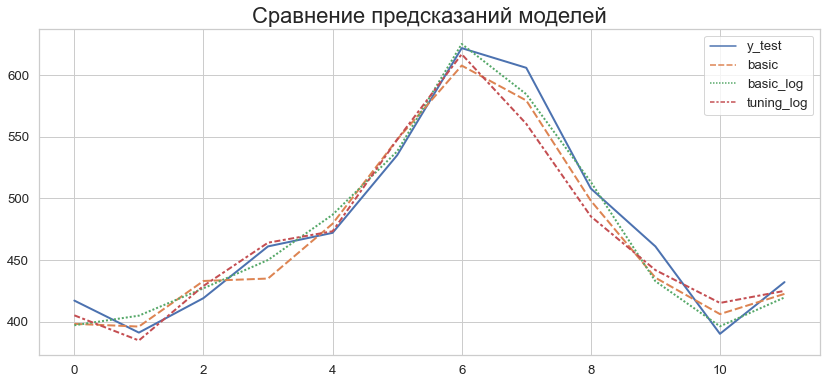

In [62]:
lp = sns.lineplot(data=all_preticts_df, linewidth = 2)
sets_for_plot(lp, title='Сравнение предсказаний моделей')

In [63]:
print('MSE базовая модель: ',     round(mean_squared_error(y_test_clear, y_predict_basic), 2))
print('MSE базовая лог-модель: ', round(mean_squared_error(y_test_clear, y_predict_basic_log), 2))
print('MSE тюнинг лог-модель: ',  round(mean_squared_error(y_test_clear, y_predict_tuning_log), 2))

MSE базовая модель:  289.34
MSE базовая лог-модель:  207.74
MSE тюнинг лог-модель:  342.36


Лучшие результаты показывает базовая логарифмическая модель. Видимо повезло попасть в глобальный максимум.

Тюнинг модель сработала хуже всего, потому что задача тюнинга была уменьшить параметры и попробовать аналоги. Видимо аналоги сработали хуже, уменьшение параметров приводит к ухудшению результатов, и просто не повезло:)

# Прогноз на следующий год

In [74]:
final_X_test = generate_true_X_test(basic_model_log, X_test_log[0:1])

In [75]:
final_predict = scaler_y_log.inverse_transform(basic_model_log.predict(final_X_test))
final_predict = np.exp(final_predict)

In [76]:
final_predict.round()

array([[397.],
       [405.],
       [427.],
       [450.],
       [487.],
       [538.],
       [625.],
       [585.],
       [513.],
       [433.],
       [396.],
       [420.]], dtype=float32)